In [1]:
import numpy as np
import scipy.io as sio
%matplotlib notebook
import os
import h5py
import sklearn.linear_model as slm
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.ndimage.filters as sfi
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut
import scipy.stats as sst

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
roibase = '/home/mossing/scratch/2Pdata/180321/M7955/ot/M7955_000_002_ot_00'
roifiles = [roibase+str(i)+'.rois' for i in range(4)]
infofile = '/home/mossing/scratch/2Pdata/180321/M7955/ot/M7955_000_002_ot_000.mat'
resultfile = '/home/mossing/excitation/visual_stim/180321/M7955/M7955_000_002.mat'
traces = np.array(())
for roifile in roifiles:
    with h5py.File(roifile,mode='r') as f:
        if traces.size:
            print(f['corrected'][()].T.shape)
            try:
                traces = np.concatenate((traces,f['corrected'][()].T),axis=0)
            except:
                to_add = f['corrected'][()].T
                to_add = np.concatenate((to_add,np.zeros((to_add.shape[0],1))),axis=1)
                traces = np.concatenate((traces,to_add),axis=0)
        else:
            print(f['corrected'][()].T.shape)
            traces = f['corrected'][()].T
#     trialwise = f['trialwise'][()].T
frame = sio.loadmat(infofile, squeeze_me=True)['info'][()]['frame'][1:]
stimParams = sio.loadmat(resultfile, squeeze_me=True)['result'][()]['stimParams']

(69, 10055)
(98, 10055)
(114, 10055)
(84, 10054)


In [3]:
to_add = traces.copy()
blcutoff = 10
baseline = np.percentile(to_add,blcutoff,axis=1)
c = np.zeros_like(to_add)
s = np.zeros_like(to_add)
for i in range(c.shape[0]):
    dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
    c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
to_add = ut.trialize(to_add,frame,nbefore=8,nafter=15)
straces = s.copy()
c = ut.trialize(c,frame,nbefore=8,nafter=15)
s = ut.trialize(s,frame,nbefore=8,nafter=15)

<IPython.core.display.Javascript object>


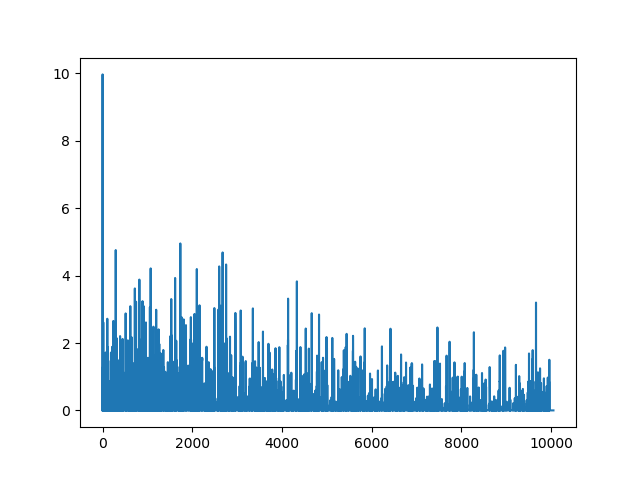

In [4]:
plt.figure()
# plt.scatter(traces[20],traces[27],alpha=0.1,s=1)
# plt.plot(traces[20])
plt.plot(straces[20])

In [5]:
# frame = matfile['frame']
# traces = matfile['traces']
# stimParams = matfile['stimParams']
# frame = matfile['frame']
# traces = matfile['corrected']
# stimParams = matfile['stimParams']
stimlen = np.diff(frame.reshape((-1,2)),axis=1).min()

In [6]:
def trialize(traces,frame,extra_before=8,extra_after=15):
    fr = frame.reshape((-1,2))
    stimlen = np.diff(fr,axis=1).min()
    ncell = traces.shape[0]
    ntrial = fr.shape[0]
    trialwise = np.zeros((ncell,ntrial,stimlen+extra_before+extra_after))
    for i in range(ntrial):
        trialwise[:,i] = traces[:,fr[i,0]-extra_before:fr[i,0]+stimlen+extra_after]
    return trialwise

In [7]:
try:
    trialrun = sio.loadmat(roifiles[0],squeeze_me=True)['trialrunning']
except:
    with h5py.File(roifiles[0],mode='r') as f:
        trialrun = f['trialrun'][:].T

In [8]:
trialrun.shape[0]

600

<IPython.core.display.Javascript object>


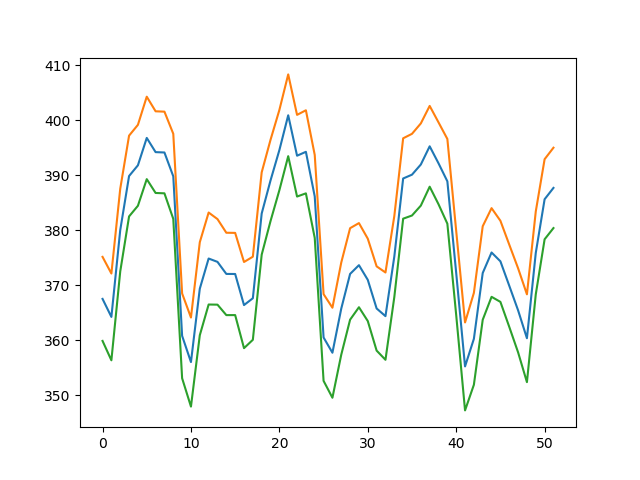

In [9]:
plt.figure()
plt.plot(trialrun[200:].mean(0))
plt.plot(trialrun[200:].mean(0)+trialrun.std(0)/np.sqrt(trialrun.shape[0]))
plt.plot(trialrun[200:].mean(0)-trialrun.std(0)/np.sqrt(trialrun.shape[0]))

<IPython.core.display.Javascript object>


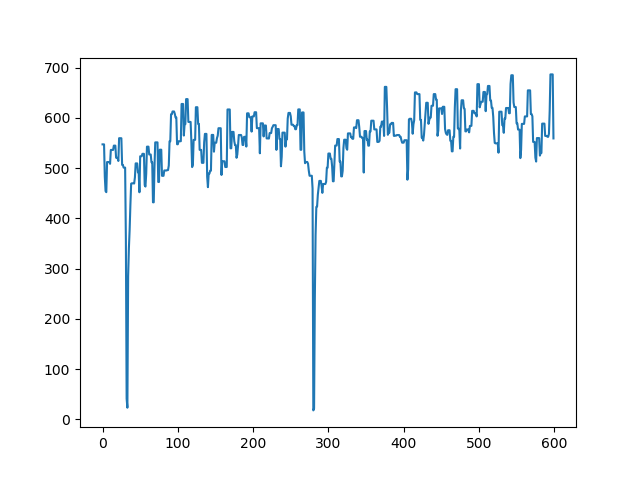

In [10]:
plt.figure()
plt.plot(trialrun.max(1))
stationary = trialrun.max(1)<50

In [11]:
# extra_before=4
# extra_after=8
extra_before=8
extra_after=15
trialwise = trialize(traces,frame,extra_before=extra_before,extra_after=extra_after)

In [12]:
pwd

'/home/mossing/Documents/notebooks/figure_ground'

In [13]:
def norm01(arr):
    return (arr-arr.min(1)[:,np.newaxis])/(arr.max(1)[:,np.newaxis]-arr.min(1)[:,np.newaxis])

In [14]:
order = ['ctrl','fig','grnd','iso','cross']
ori = stimParams[0]
sz = stimParams[1]
figContrast = stimParams[-2]
grndContrast = stimParams[-1]

paramdict = {}
paramdict['ctrl'] = np.logical_and(figContrast==0,grndContrast==0)
paramdict['fig'] = np.logical_and(figContrast==1,grndContrast==0)
paramdict['grnd'] = np.logical_and(np.logical_and(figContrast==0,grndContrast==1),sz>0)
paramdict['iso'] = sz==0
paramdict['cross'] = np.logical_and(figContrast==1,grndContrast==1)

In [15]:
(np.isnan(traces)).sum()

0

In [16]:
def zscore(trialwise):
    arr = trialwise.reshape((trialwise.shape[0],trialwise.shape[1]*trialwise.shape[2]))
    arr = (arr-arr.mean(1)[:,np.newaxis])/arr.std(1)[:,np.newaxis]
    return arr.reshape(trialwise.shape)

In [17]:
zstrialwise = sst.zscore(s.reshape((s.shape[0],-1)).T).T.reshape(s.shape)

In [18]:
orilist = np.unique(ori)
nori = len(orilist)
# dimensions are cell X other fig/gd/etc. X orientation X rep no X time
# resp = np.zeros((zs.shape[0],5,nori,5,zs.shape[-1]))
resp = np.zeros((s.shape[0],5,nori,15,s.shape[-1]))
running = np.zeros(resp.shape[1:-1]+trialrun.shape[-1:])
for i,name in enumerate(order):
    for j,angle in enumerate(orilist):
        resp[:,i,j,:,:] = zstrialwise[:,np.logical_and(ori==angle,paramdict[name]),:]
        running[i,j,:,:] = trialrun[np.logical_and(ori==angle,paramdict[name]),:]

In [19]:
def print_multipage(t,arr,fn,filename):
    from matplotlib.backends.backend_pdf import PdfPages
    plt.close()
    with PdfPages(filename+'.pdf') as pdf:
        for i in range(arr.shape[0]):
            fn(t,arr[i])
            pdf.savefig()
            plt.close()

In [20]:
t = np.arange(-extra_before,stimlen+extra_after)/(15.5/2)

In [21]:
def fill_in_sem(t,arr,c='b'):
    mn = arr.mean(0)
    sem = arr.std(0)/np.sqrt(arr.shape[0])
    squiggle = plt.fill_between(t,mn-sem,mn+sem,facecolor=c,alpha=0.5)
    return squiggle

In [22]:
def plotZs(t,arr):
    for i in range(8):
        plt.subplot(3,4,i+1)
        ishift = np.remainder(i-2,8)
        squig_fig = fill_in_sem(t,arr[1,i],c='b')
        squig_ground = fill_in_sem(t,arr[2,ishift],c='g')
        squig_iso = fill_in_sem(t,arr[3,ishift],c='m')
        squig_cross = fill_in_sem(t,arr[4,i],c='c')
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        plt.ylim((arr.mean(3).min()-arr.std(3).max(),arr.mean(3).max()+arr.std(3).max()))
    plt.subplot(3,4,12)
    plt.axis('off')
    plt.legend((squig_fig,squig_ground,squig_iso,squig_cross),('figure only','ground only','iso','cross'))

In [41]:
fig_responsive = (resp[:,1].mean(1).mean(1)-resp[:,1].mean(1).std(1)/np.sqrt(40)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
grnd_responsive = (resp[:,2].mean(1).mean(1)-resp[:,2].mean(1).std(1)/np.sqrt(40)).max(1)>(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
lkat = np.logical_and(~fig_responsive,grnd_responsive) #~grnd_responsive)

In [42]:
grnd_responsive.sum()

160

In [23]:
resp[lkat].shape

NameError: name 'lkat' is not defined

<IPython.core.display.Javascript object>


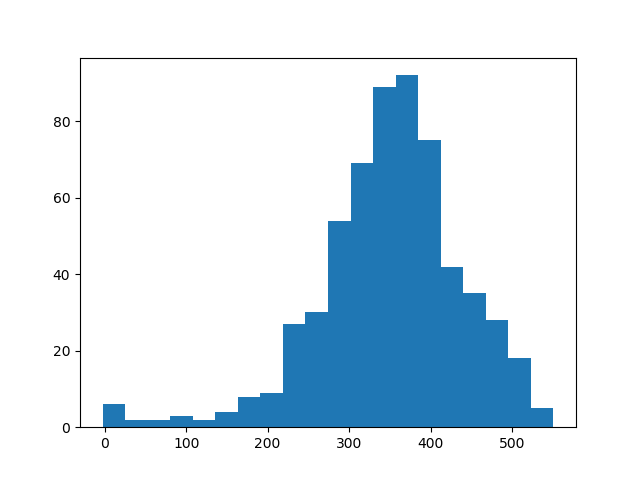

(array([  6.,   2.,   2.,   3.,   2.,   4.,   8.,   9.,  27.,  30.,  54.,
         69.,  89.,  92.,  75.,  42.,  35.,  28.,  18.,   5.]),
 array([  -2.6919663 ,   24.99109707,   52.67416044,   80.3572238 ,
         108.04028717,  135.72335054,  163.40641391,  191.08947728,
         218.77254065,  246.45560402,  274.13866739,  301.82173076,
         329.50479412,  357.18785749,  384.87092086,  412.55398423,
         440.2370476 ,  467.92011097,  495.60317434,  523.28623771,
         550.96930108]),
 <a list of 20 Patch objects>)

In [24]:
plt.figure()
plt.hist(trialrun.mean(-1),20)

In [29]:
s.shape

(365, 600, 31)

<IPython.core.display.Javascript object>


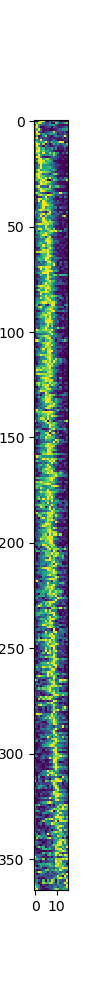

In [25]:
plt.figure(figsize=(1,10))
data = ut.norm01(s[:,:300].mean(1)[:,8:-7])
pksort = np.argsort(np.argmax(data,axis=1))
data = ut.norm01(s[:,300:].mean(1)[:,8:-7])
plt.imshow(data[pksort])

In [29]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

In [26]:
resp.shape

(365, 5, 8, 15, 31)

In [27]:
prefsort = np.argsort(np.argmax(resp[:,:,:,:,8:-15].mean(-1).mean(-1).mean(-1),axis=1))

In [28]:
preffed = np.argmax(resp[:,:,:,:,8:-15].mean(-1).mean(-1).mean(-1),axis=1)[prefsort]
border = np.where(np.diff(preffed))[0]

In [29]:
# resp[prefsort][12][1][:,:,8:-15].mean(-1.shape

<IPython.core.display.Javascript object>


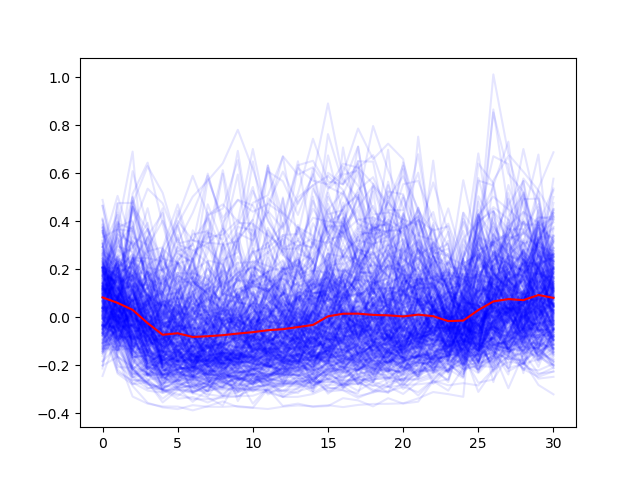

In [30]:
plt.figure()
plt.plot(resp[:,0,:,:,:].mean(-2).mean(-2).T,alpha=0.1,c='b')
plt.plot(resp[:,0,:,:,:].mean(0).mean(-2).mean(-2),c='r')

In [52]:
ret = sio.loadmat('../retinotopy/retinotopy_0321.mat')['ret_run']

In [31]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

<IPython.core.display.Javascript object>


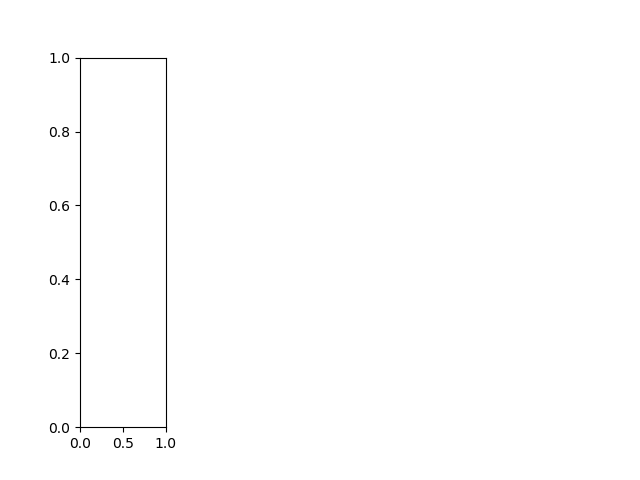

NameError: name 'ret' is not defined

In [32]:
plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(np.nanmean(ret[prefsort][preffed==i],axis=0),vmax=np.nanmax(ret)/10)
    plt.axis('off')

In [37]:
(preffed==2).sum()

130

<IPython.core.display.Javascript object>


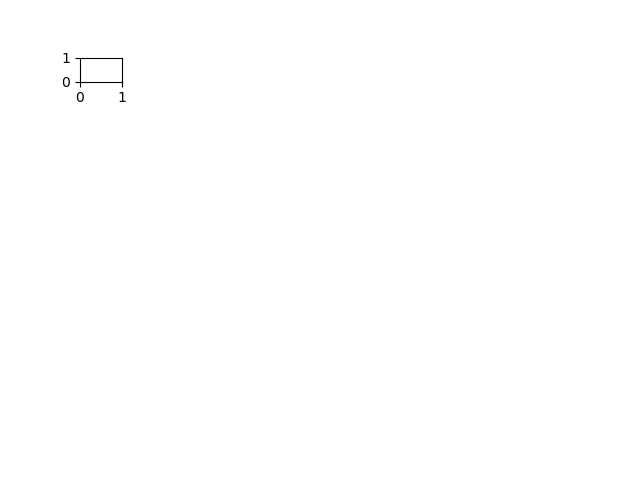

NameError: name 'ret' is not defined

In [33]:
plt.figure()
for j in range((preffed==4).sum()):
    plt.subplot(13,10,j+1)
    if np.isnan(ret[prefsort][preffed==4][j]).sum():
        print("couldn't do "+str(j))
        plt.axis('off')
    else:
        plt.imshow(ret[prefsort][preffed==4][j])
        plt.axis('off')
        

In [34]:
fig_responsive = (resp[:,1].mean(1).mean(1)-resp[:,1].mean(1).std(1)/np.sqrt(40)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
grnd_responsive = (resp[:,2].mean(1).mean(1)-resp[:,2].mean(1).std(1)/np.sqrt(40)).max(1)>(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
lkat = np.logical_and(fig_responsive,~grnd_responsive)

<IPython.core.display.Javascript object>


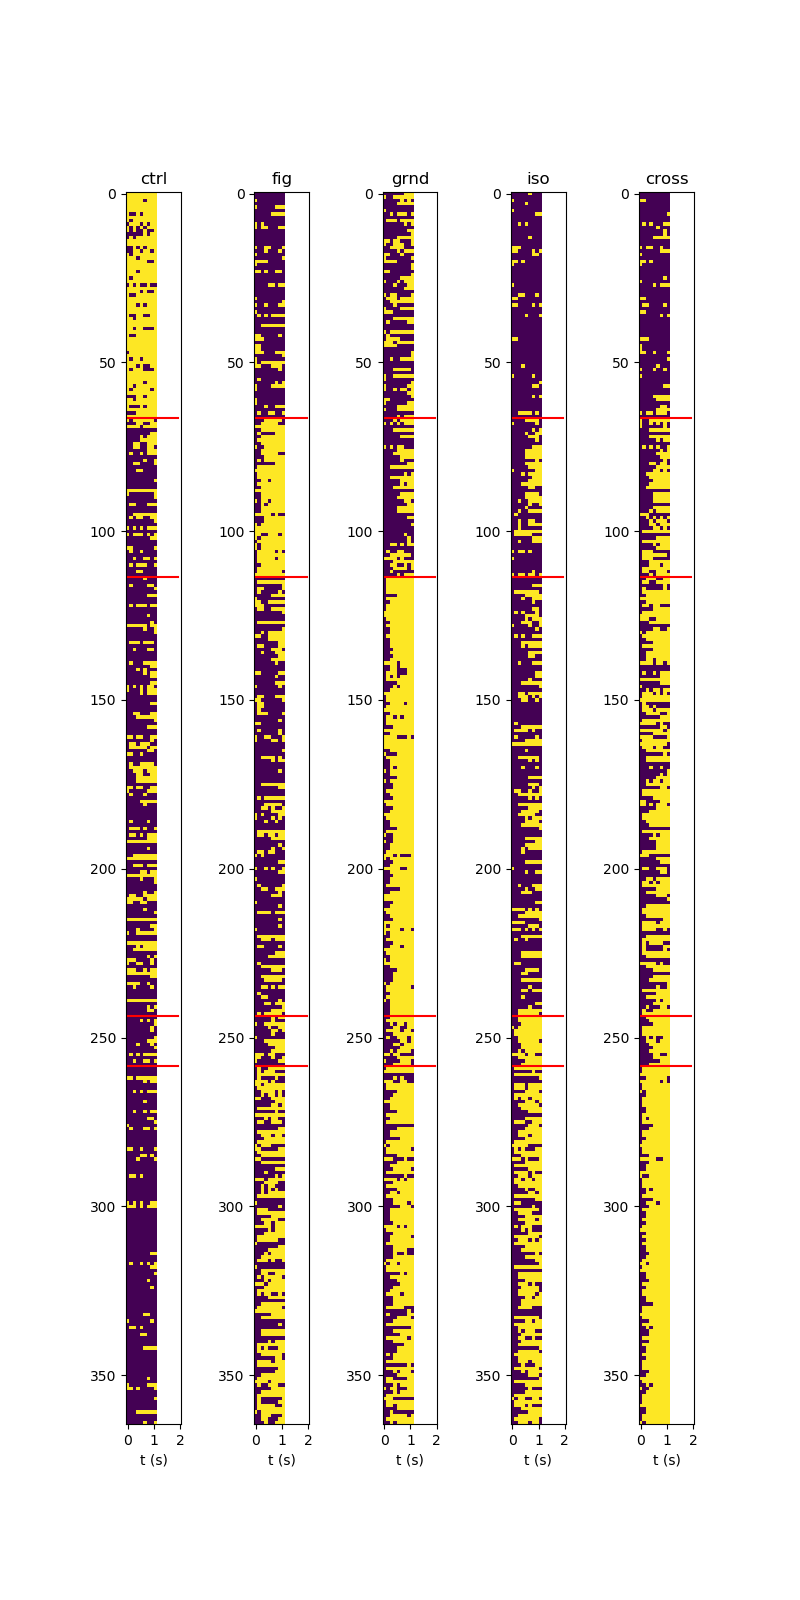

In [35]:
plt.figure(figsize=(8,16))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.imshow(resp[prefsort][:,k].mean(1).mean(1)[:,8:-14],vmin=0,vmax=resp.mean(1).mean(1).mean(1).mean(1).max())
    for j in range(len(border)):
        plt.plot((0,15),(border[j]+0.5,border[j]+0.5),c='r')
    plt.xticks((0,7.75,15.5),(0,1,2))
    plt.title(order[k])
    plt.xlabel('t (s)')

In [36]:
resptavg = resp[:,:].mean(2).mean(2)[:,:,8:-14].mean(-1)

In [41]:
matdict = {}
matdict['dataX'] = resptavg[:,-2]
matdict['dataY'] = resptavg[:,-1]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate iso-oriented'
matdict['labelY'] = 'z-scored event rate cross-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('vip_iso_cross_180321.mat',matdict)

In [42]:
matdict = {}
matdict['dataX'] = resptavg[:,1]
matdict['dataY'] = resptavg[:,3]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate center only'
matdict['labelY'] = 'z-scored event rate iso-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('vip_center_iso_180321.mat',matdict)

<IPython.core.display.Javascript object>


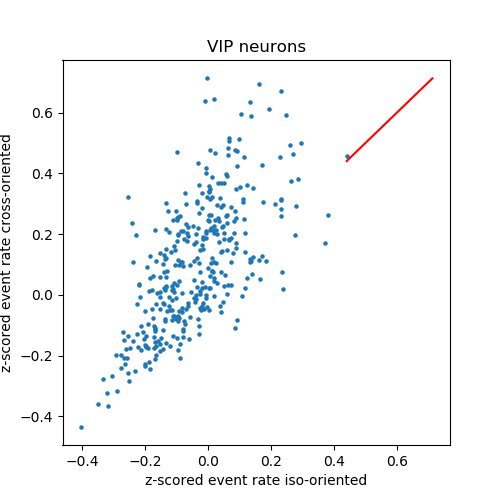

Text(0.5,1,'VIP neurons')

In [40]:
plt.figure(figsize=(5,5))
plt.scatter(resptavg[:,-2],resptavg[:,-1],s=5)
mnm = np.minimum(resptavg[:,-2].max(),resptavg[:,-1].max())
mxm = np.maximum(resptavg[:,-2].max(),resptavg[:,-1].max())
plt.plot((mnm,mxm),(mnm,mxm),c='r')
# plt.xlim((0,mxm))
# plt.ylim((0,mxm))
plt.xlabel('z-scored event rate iso-oriented')
plt.ylabel('z-scored event rate cross-oriented')
plt.title('VIP neurons')
# plt.savefig('vip_iso_cross.eps')

<IPython.core.display.Javascript object>


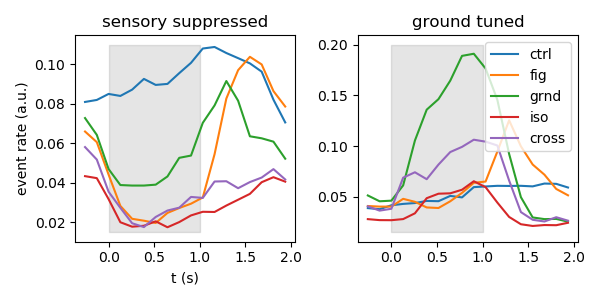

In [35]:
t = np.arange(-2,16)/7.75
plt.figure(figsize=(6,3))
# plt.hspace(10)
plt.subplot(1,2,1)
plt.title('sensory suppressed')
plt.plot(t,resp[prefsort][preffed==0].mean(0).mean(-2).mean(-2).T[6:-7])
plt.fill_between((0,1),(0.015,0.015),(0.11,0.11),alpha=0.1,color='k')
plt.xlabel('t (s)')
plt.ylabel('event rate (a.u.)')
plt.subplot(1,2,2)
plt.title('ground tuned')
plt.plot(t,resp[prefsort][preffed==2].mean(0).mean(-2).mean(-2).T[6:-7])
plt.fill_between((0,1),(0.015,0.015),(0.2,0.2),alpha=0.1,color='k')
plt.legend(order,loc='upper right')
plt.tight_layout()

In [262]:
(preffed>-1).sum()

365

These are "spike rates" deconvolved using OASIS. In these data, the stimuli were delivered between 0 and 1 second. "Ctrl" refers to catch trials, in which the screen remained gray during the stim delivery. From these plots, the following observations are made: 

1. A subset of VIP neurons (67/365) are spontaneously active and suppressed by all the sensory stimuli shown.

2. 

<IPython.core.display.Javascript object>


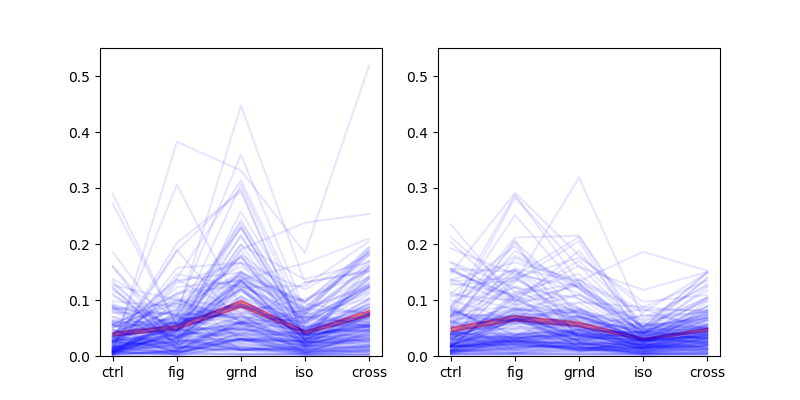

([<matplotlib.axis.XTick at 0x7fbcbda43be0>,
 <a list of 5 Text xticklabel objects>)

In [209]:
plt.figure(figsize=(8,4))
summary_onset = resp[:,:,:,:,8:-15].mean(-1).mean(-1).mean(-1)
lb_onset,ub_onset = ut.bootstrap(summary_onset,np.mean,pct=(16,84))
summary_offset = resp[:,:,:,:,-15:-8].mean(-1).mean(-1).mean(-1)
lb_offset,ub_offset = ut.bootstrap(summary_offset,np.mean,pct=(16,84))
plt.subplot(1,2,1)
plt.plot(summary_onset.T,c='b',alpha=0.1)
plt.fill_between((0,1,2,3,4),lb_onset,ub_onset,color='r',alpha=0.5)
plt.ylim((0,0.55))
plt.xticks((0,1,2,3,4),order)
plt.subplot(1,2,2)
plt.plot(summary_offset.T,c='b',alpha=0.1)
plt.fill_between((0,1,2,3,4),lb_offset,ub_offset,color='r',alpha=0.5)
plt.ylim((0,0.55))
plt.xticks((0,1,2,3,4),order)

<IPython.core.display.Javascript object>


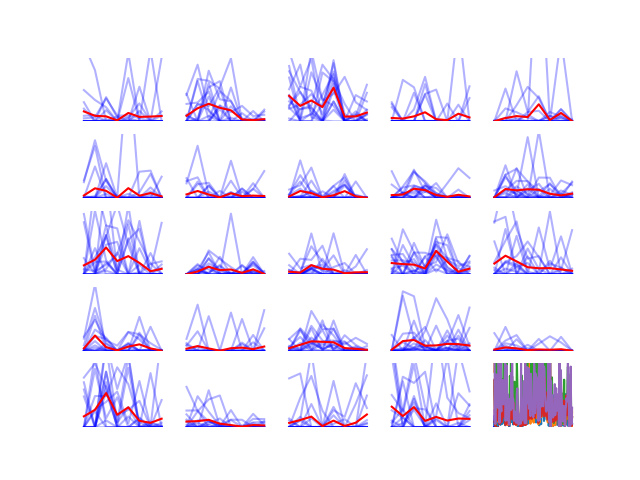

In [148]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][3,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][3,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][3].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


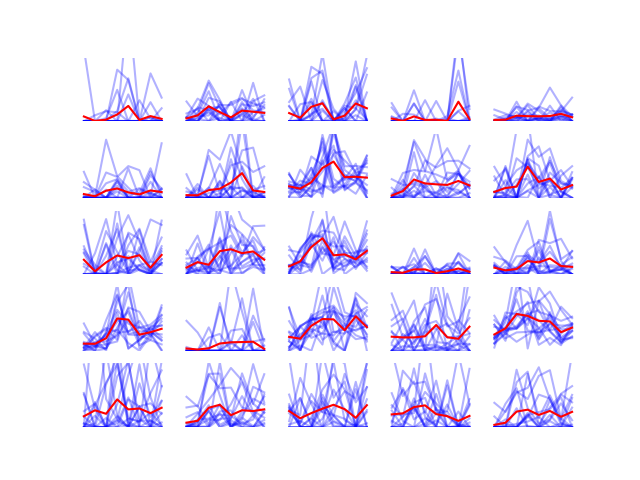

In [145]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][1,:,:,8:-15].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][1].mean(1).max())
    plt.axis('off')

In [ ]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][1].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][1].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][1].mean(-1).mean(1).max()+0.1)
    plt.axis('off')

In [134]:
resp[0][1].shape

(8, 15, 31)

In [ ]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


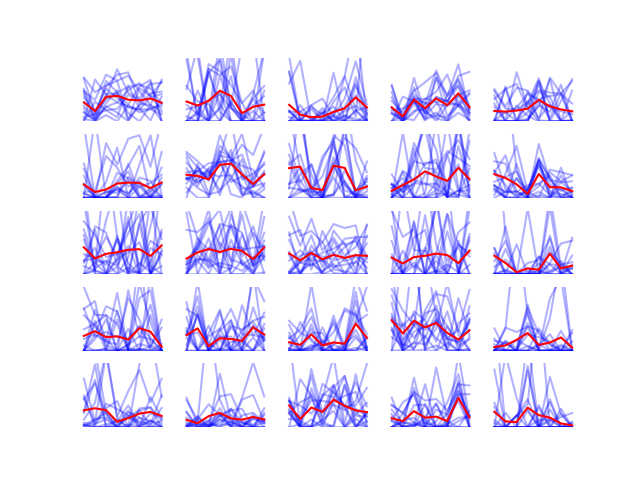

In [141]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


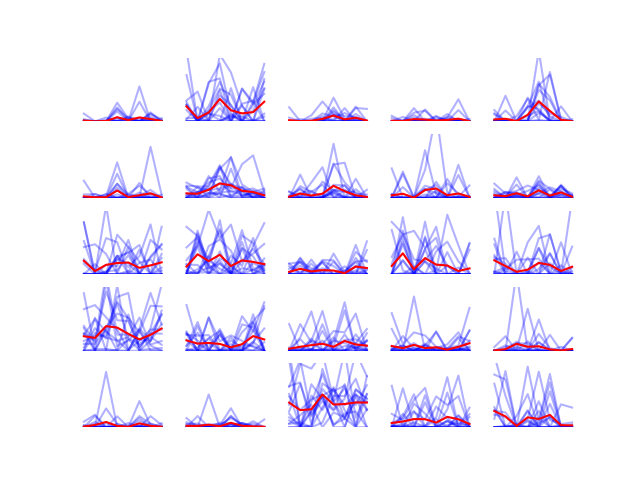

In [142]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,8:-15].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


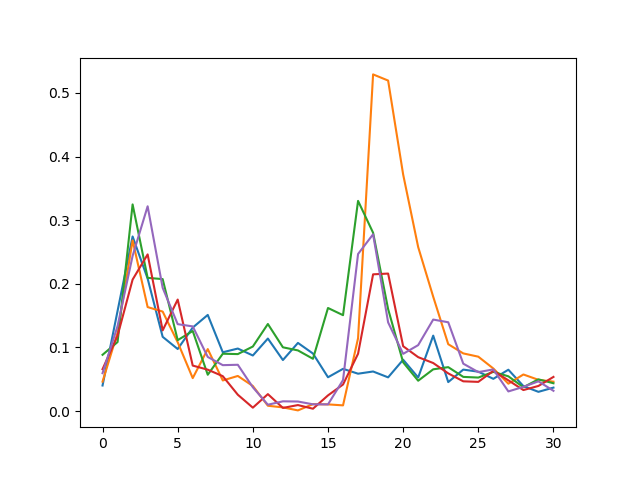

In [96]:
plt.figure()
plt.plot(resp[pksort][140].mean(1).mean(1).T)

<IPython.core.display.Javascript object>


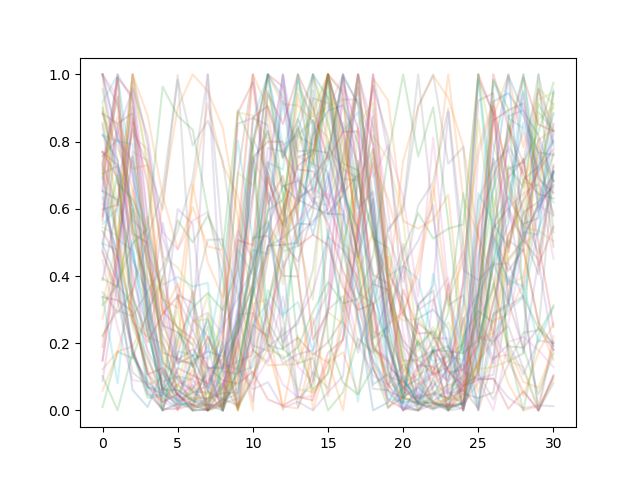

In [46]:
plt.figure()
plt.plot(ut.norm01(s.mean(1)).T,alpha=0.2)

<IPython.core.display.Javascript object>


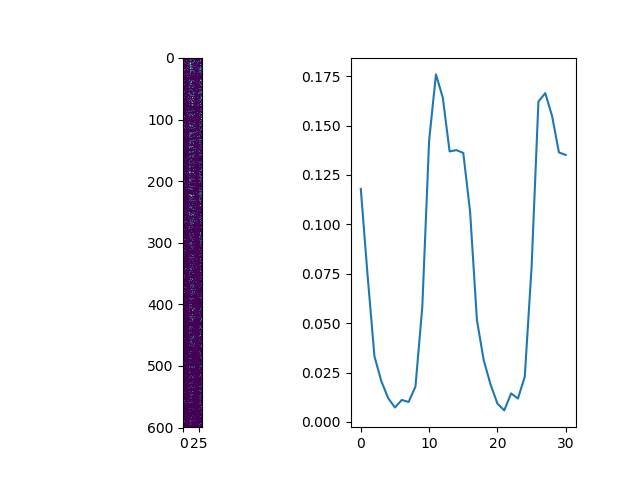

In [39]:
k = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(s[k])
plt.subplot(1,2,2)
plt.plot(s[k].mean(0))

<IPython.core.display.Javascript object>


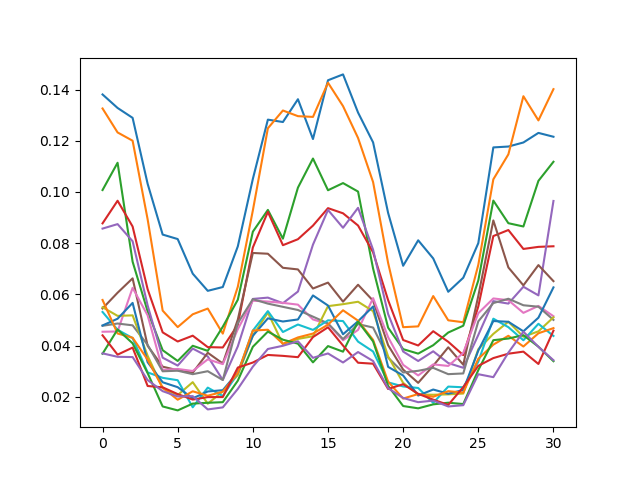

In [232]:
plt.figure()
plt.plot(resp.mean(0).mean(0).mean(0).T)

<IPython.core.display.Javascript object>


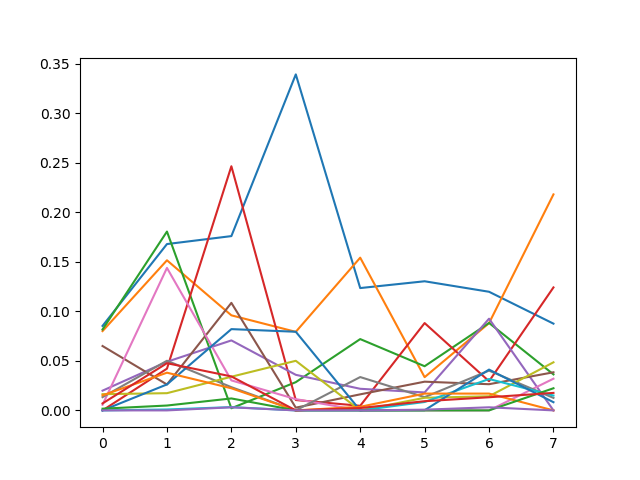

In [233]:
# plt.plot(resp[27,2].mean(-1))
# plt.plot(resp[2,2].mean(-1))
plt.plot(resp[33,3].mean(-1))

<IPython.core.display.Javascript object>


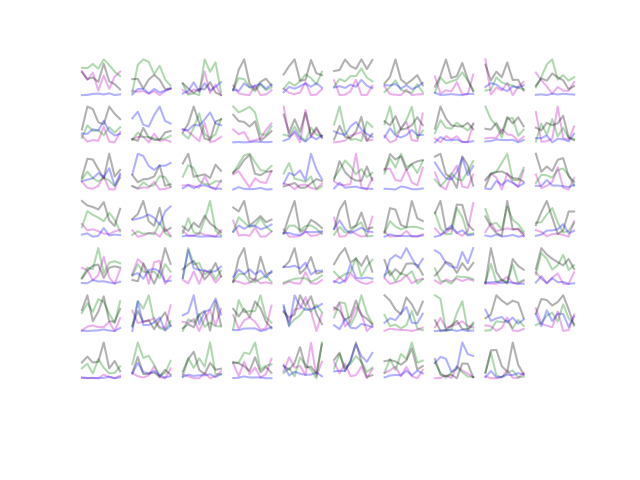

In [244]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1).mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

<IPython.core.display.Javascript object>


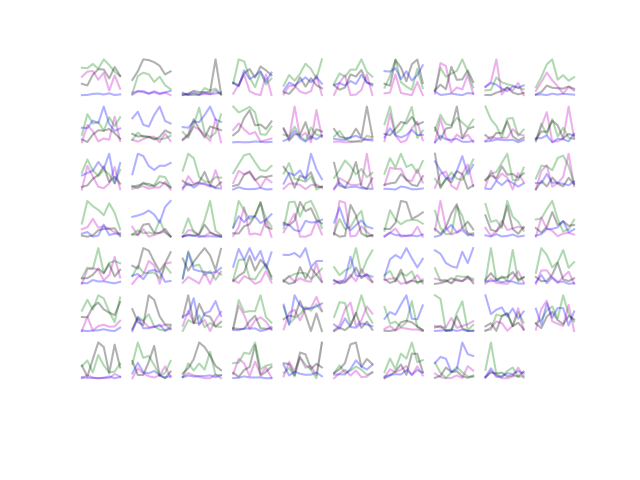

In [243]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

In [235]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

<IPython.core.display.Javascript object>


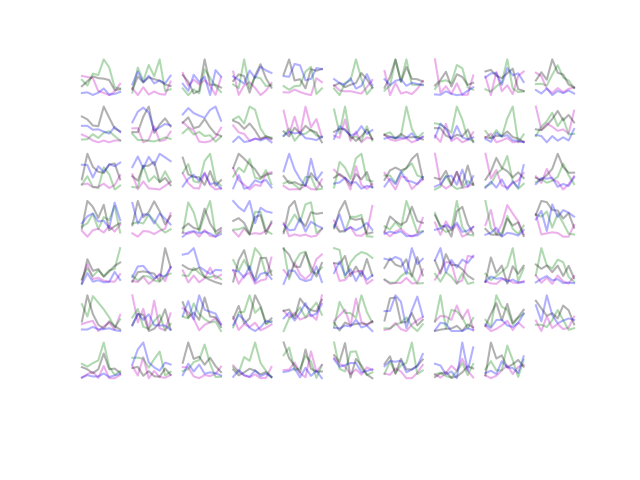

In [245]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
    # magenta: iso, green: cross, black: grnd
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,-15:-8].mean(-1).mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

<IPython.core.display.Javascript object>


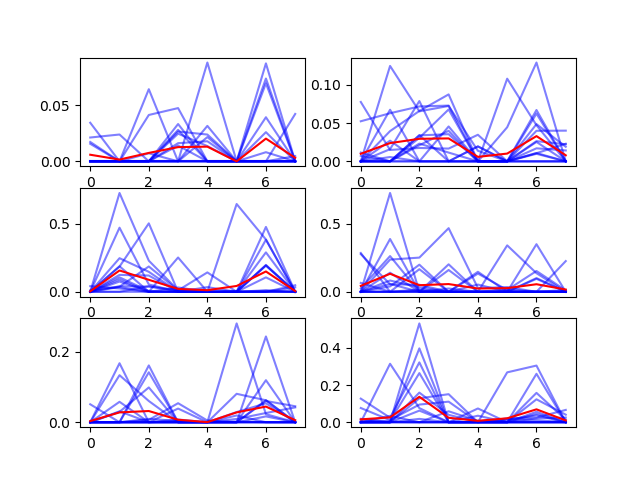

In [239]:
plt.figure()
K = 11
plt.subplot(3,2,1)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,2)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 20
plt.subplot(3,2,3)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,4)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 27
plt.subplot(3,2,5)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,6)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')

<IPython.core.display.Javascript object>


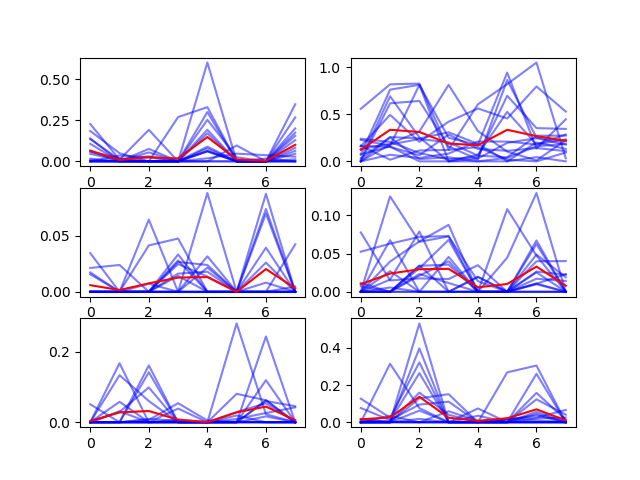

In [241]:
plt.figure()
K = 10
plt.subplot(3,2,1)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))].mean(-1),c='r')
plt.subplot(3,2,2)
plt.plot(resp[lkat][K,2,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,2,:,:,8:-15].mean(-1).mean(-1),c='r')
K = 11
plt.subplot(3,2,3)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,4)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 27
plt.subplot(3,2,5)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,6)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')

<IPython.core.display.Javascript object>


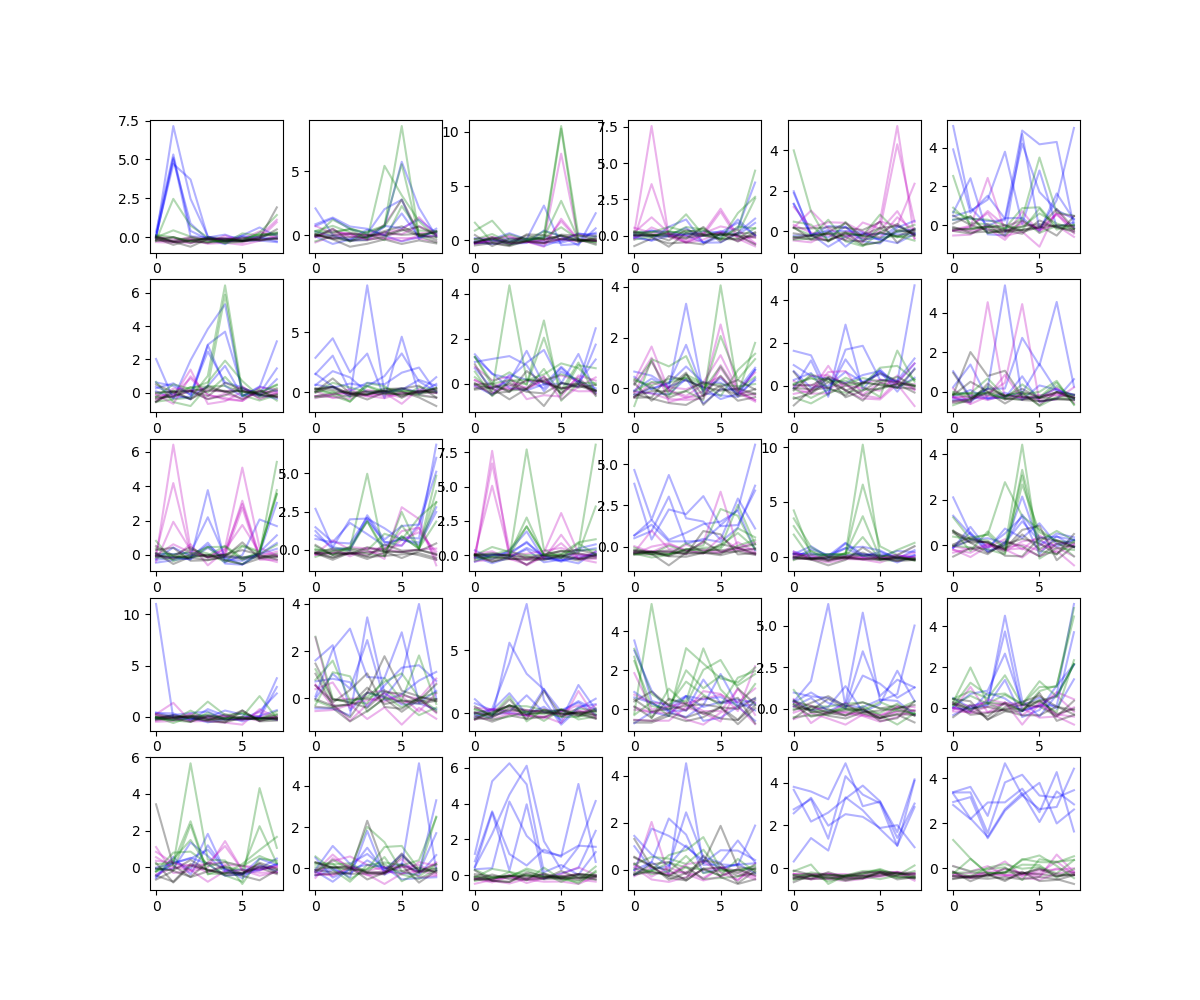

In [87]:
plt.figure(figsize=(12,10))
for i in range(lkat.sum()):
    plt.subplot(5,6,i+1)
    plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1),alpha=0.3,c='k')

<IPython.core.display.Javascript object>


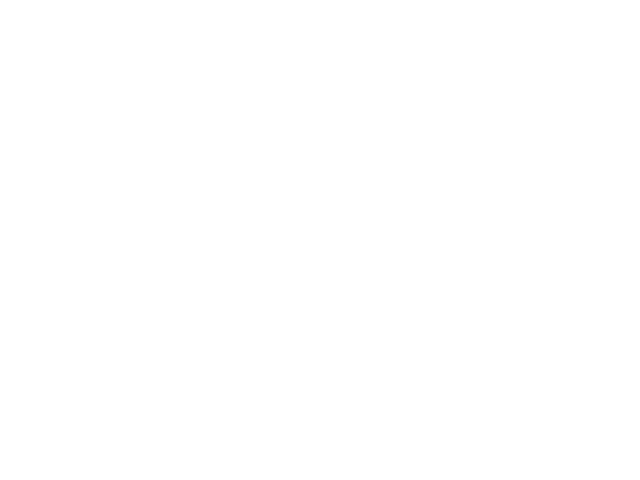

<IPython.core.display.Javascript object>


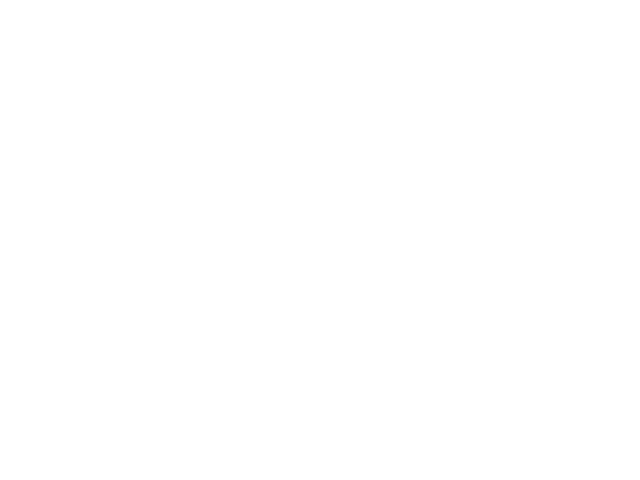

<IPython.core.display.Javascript object>


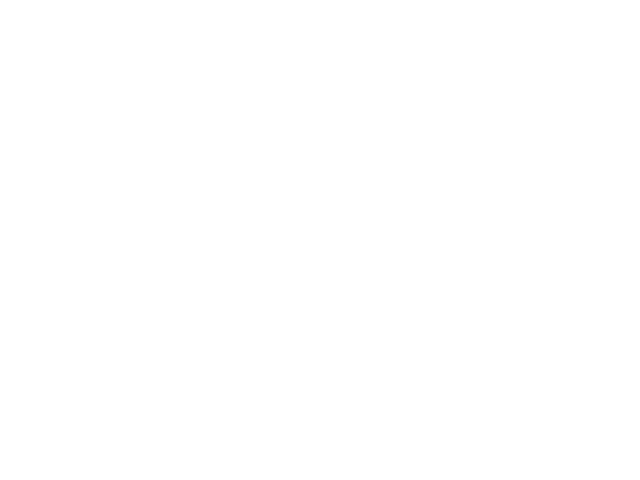

<IPython.core.display.Javascript object>


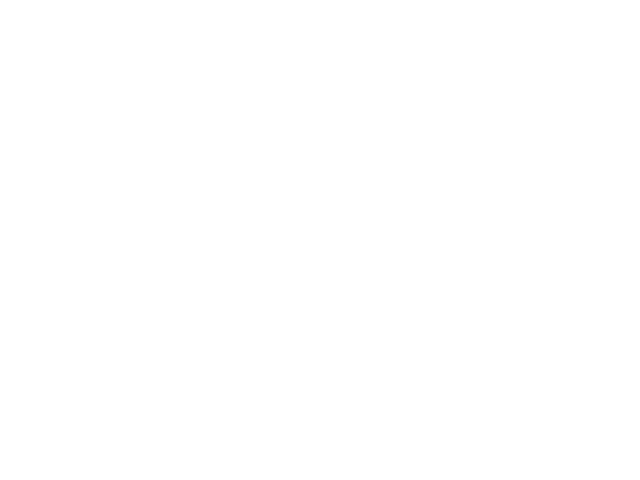

<IPython.core.display.Javascript object>


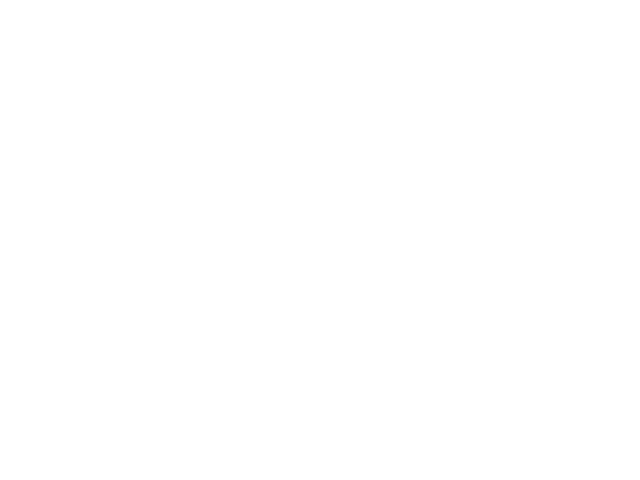

<IPython.core.display.Javascript object>


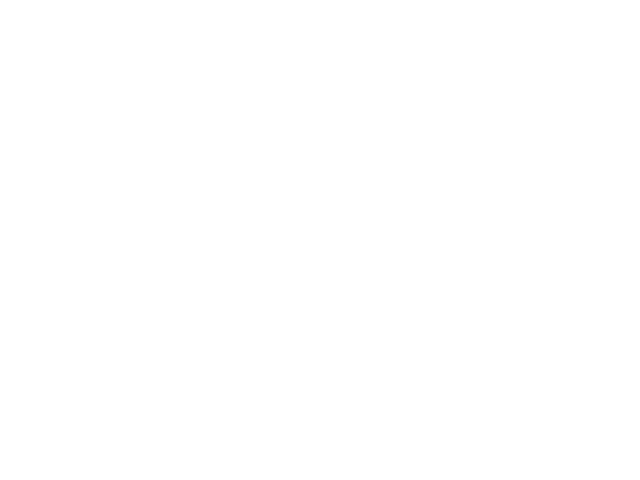

<IPython.core.display.Javascript object>


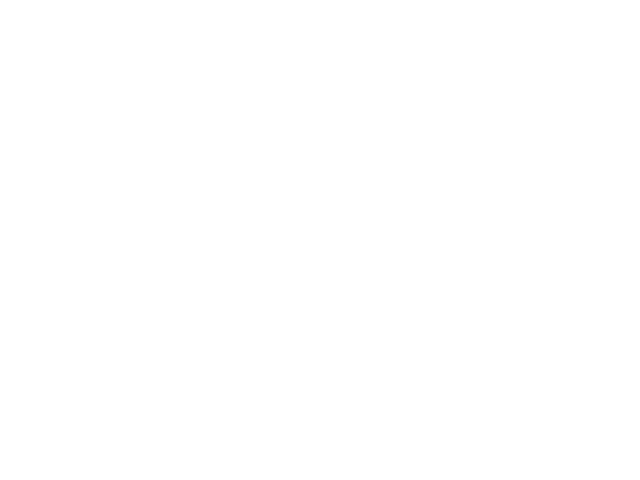

<IPython.core.display.Javascript object>


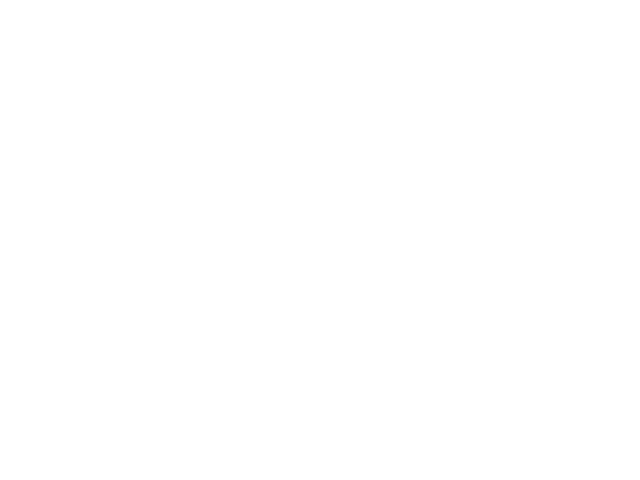

<IPython.core.display.Javascript object>


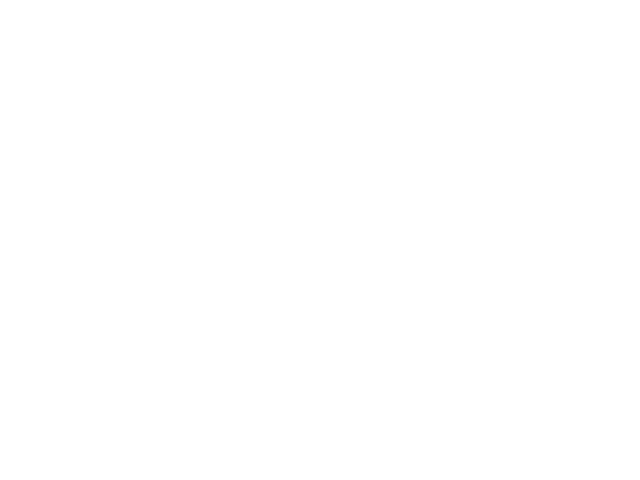

<IPython.core.display.Javascript object>


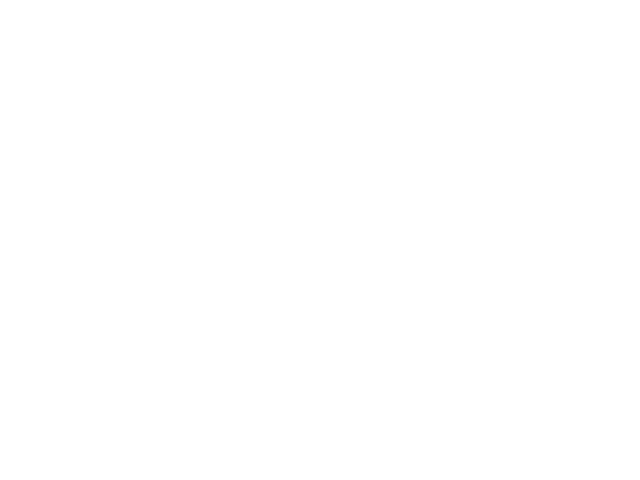

<IPython.core.display.Javascript object>


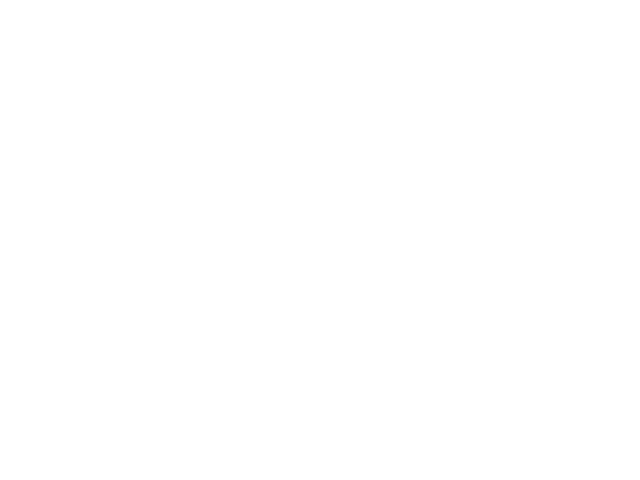

<IPython.core.display.Javascript object>


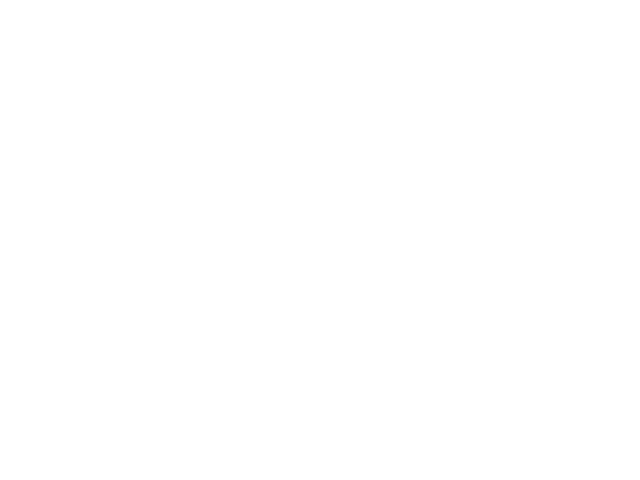

<IPython.core.display.Javascript object>


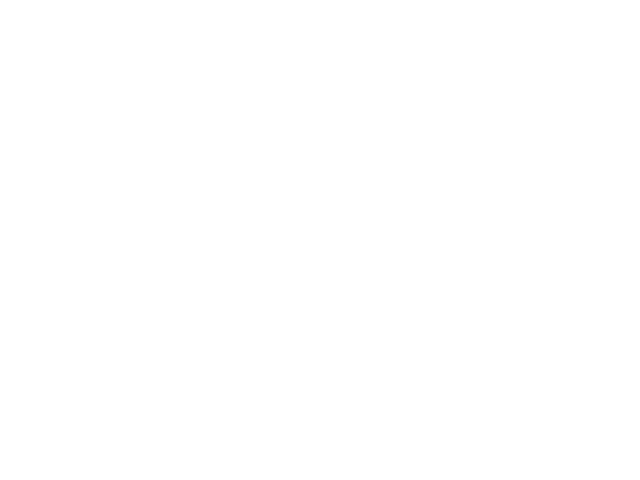

<IPython.core.display.Javascript object>


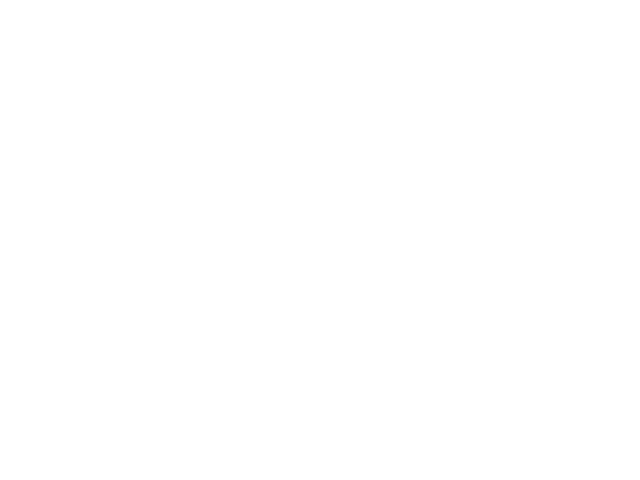

<IPython.core.display.Javascript object>


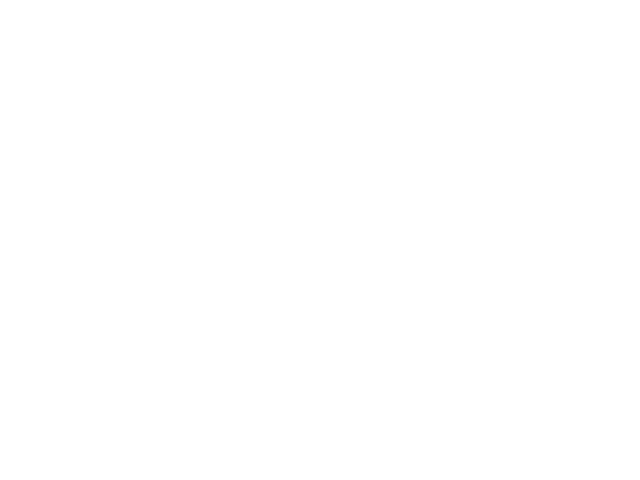

<IPython.core.display.Javascript object>


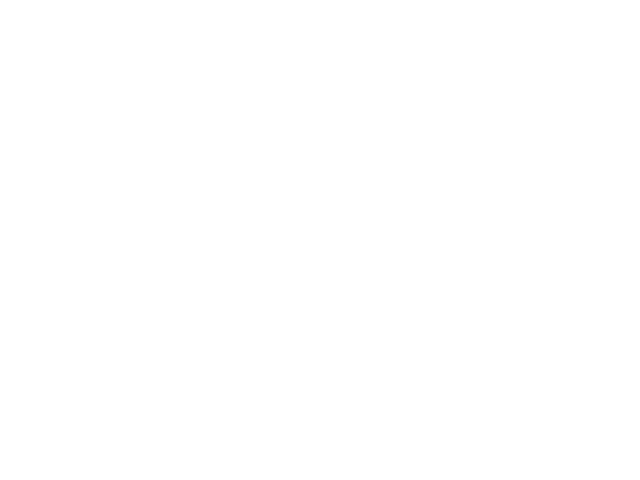

<IPython.core.display.Javascript object>


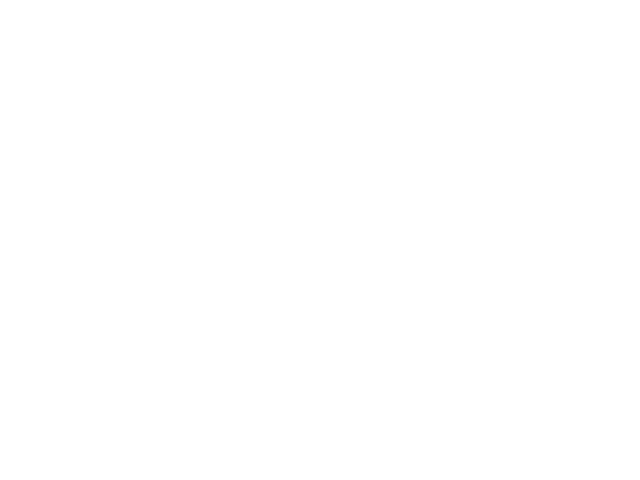

<IPython.core.display.Javascript object>


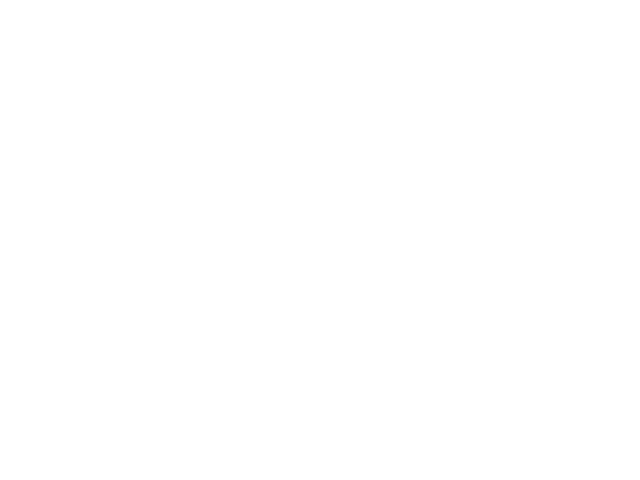

<IPython.core.display.Javascript object>


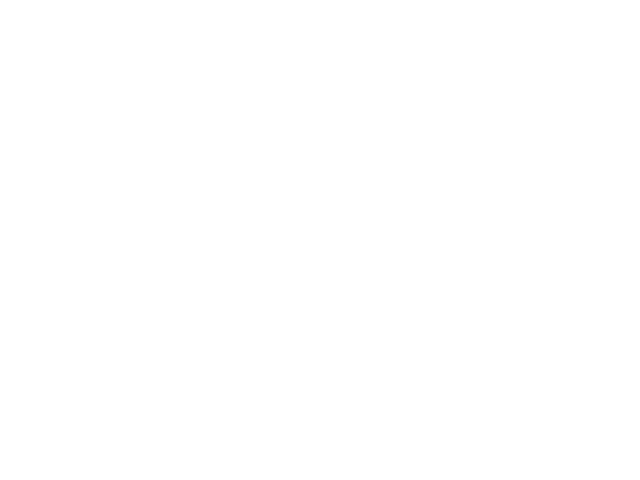

<IPython.core.display.Javascript object>


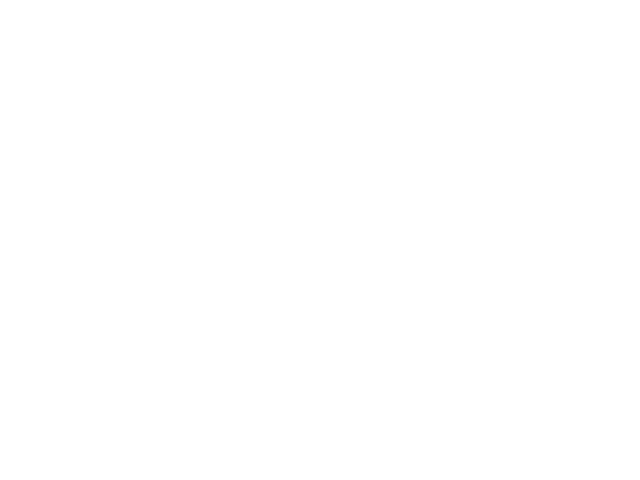

<IPython.core.display.Javascript object>


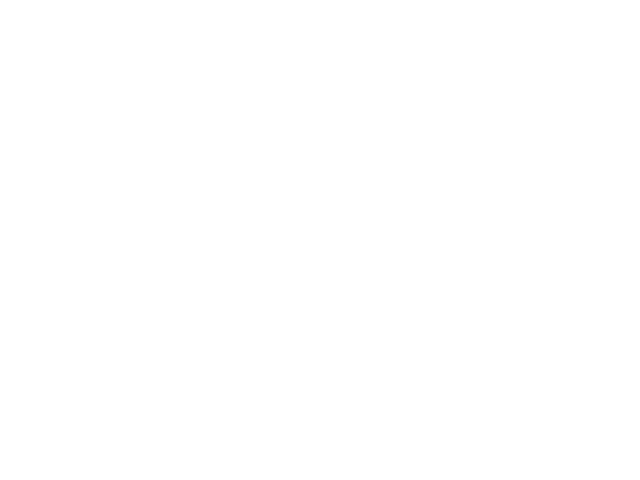

<IPython.core.display.Javascript object>


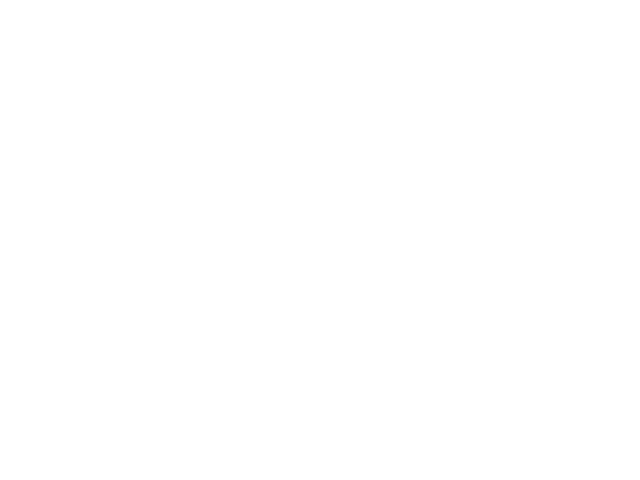

<IPython.core.display.Javascript object>


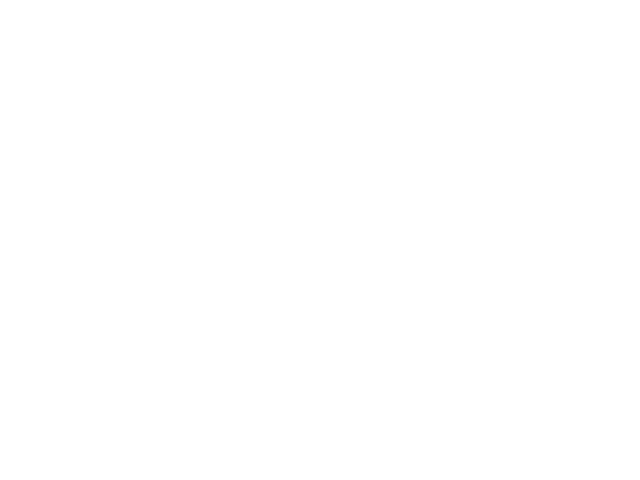

<IPython.core.display.Javascript object>


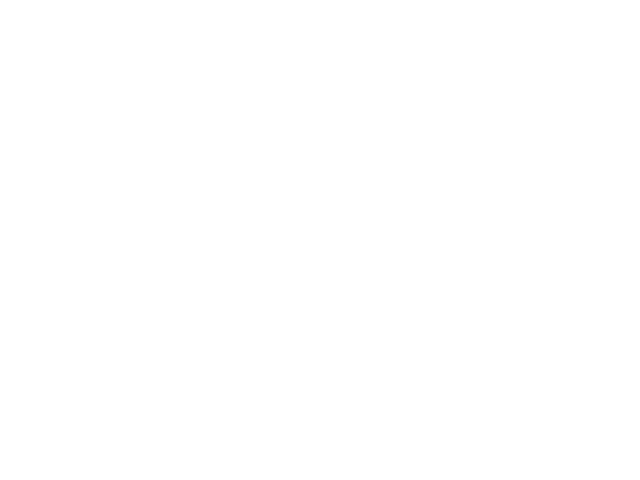

<IPython.core.display.Javascript object>


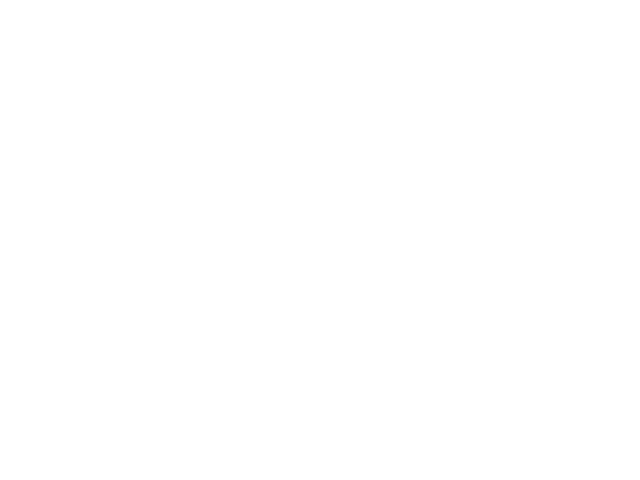

<IPython.core.display.Javascript object>


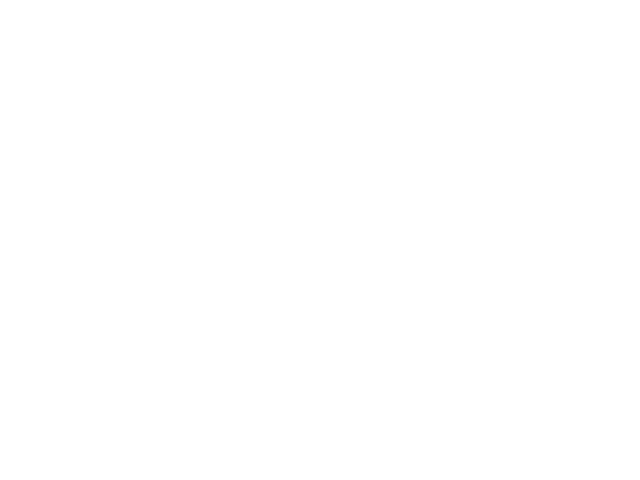

<IPython.core.display.Javascript object>


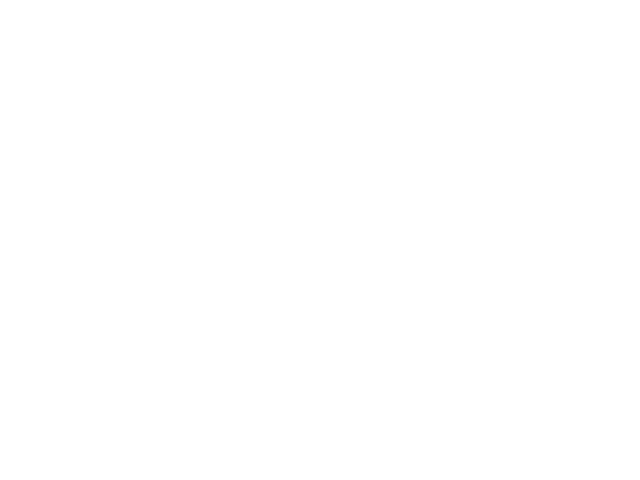

<IPython.core.display.Javascript object>


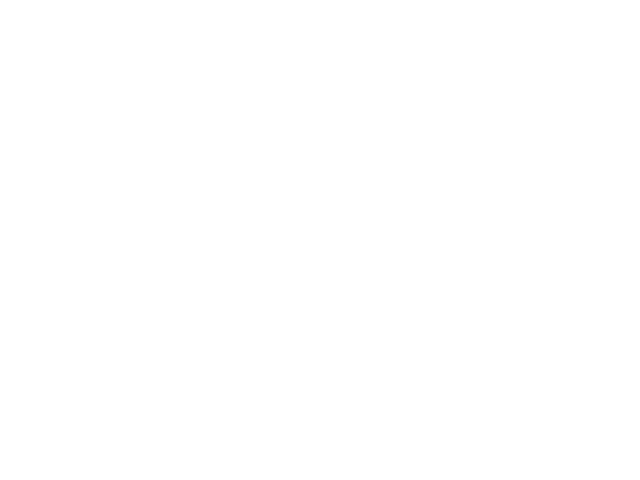

<IPython.core.display.Javascript object>


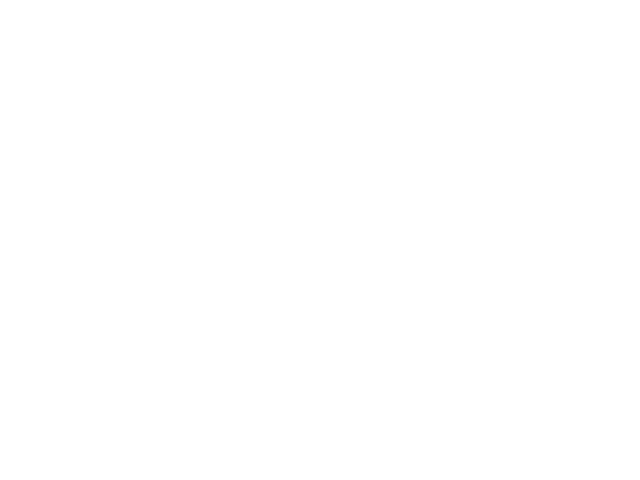

<IPython.core.display.Javascript object>


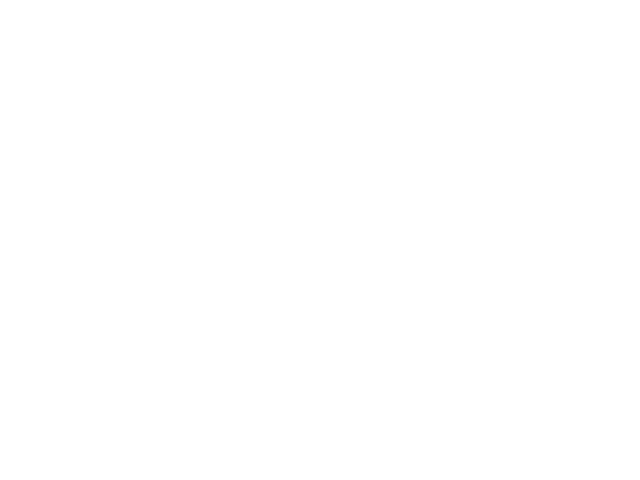

In [68]:
print_multipage(t,resp[lkat],plotZs,'fig_responsive')

In [25]:
peakinds = np.argmax(sfi.gaussian_filter(resp[:,4],sigma=(0,0,0,2)).mean(1).mean(1),axis=1)
order_by_peak = np.argsort(peakinds)
peaksort = peakinds[order_by_peak]

In [26]:
isresponsive = fig_responsive = (resp[:,1:5].mean(1).mean(1).mean(1)-resp[:,1:5].mean(1).mean(1).std(1)/np.sqrt(160)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)

In [27]:
isresponsive.sum()

37

In [28]:
avgresp = resp[:,1:4].mean(1).mean(1).mean(1)

<IPython.core.display.Javascript object>


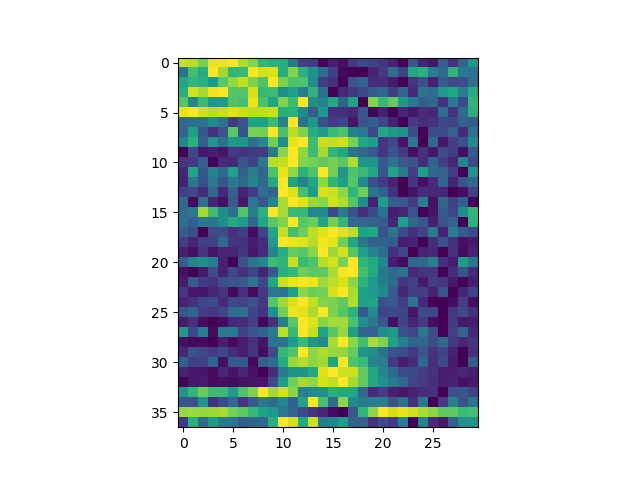

In [29]:
plt.imshow(norm01(avgresp[order_by_peak[isresponsive]]),interpolation='nearest',cmap=plt.cm.viridis)

In [30]:
ontarget = resp[lkat].mean(-1)
ontarget = ontarget[:,1:]-ontarget[:,0:1]

In [31]:
gd = np.where(isresponsive)[0]

In [32]:
tracez = (traces-traces.mean(1)[:,np.newaxis])/traces.std(1)[:,np.newaxis]

In [33]:
np.outer(isresponsive,paramdict['cross']).shape

(79, 200)

In [37]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
mx = np.maximum(Ccross.max(),Cfig.max())
mn = np.maximum(Ccross.min(),Cfig.min())

<IPython.core.display.Javascript object>


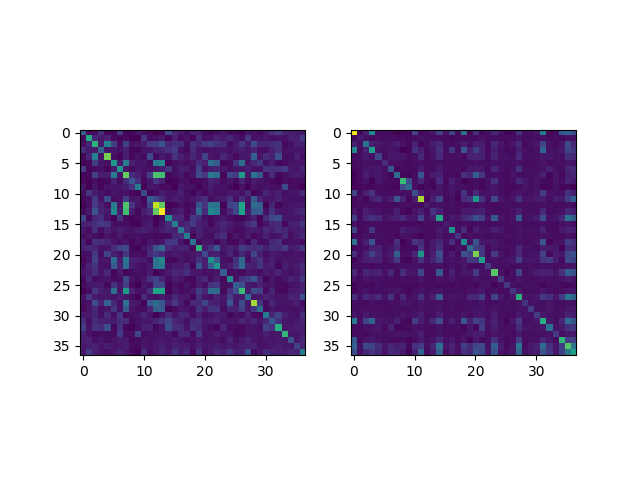

In [40]:
plt.subplot(1,2,1)
plt.imshow(Ccross,vmax=mx,vmin=mn)
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Cfig,vmax=mx,vmin=mn)
# plt.colorbar()

In [351]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
Cgrnd = np.cov(zs[isresponsive][:,paramdict['grnd']].reshape((isresponsive.sum(),-1)))
Ciso = np.cov(zs[isresponsive][:,paramdict['iso']].reshape((isresponsive.sum(),-1)))
ucross,scross,vcross = np.linalg.svd(Ccross)
ufig,sfig,vfig = np.linalg.svd(Cfig)
ugrnd,sgrnd,vgrnd = np.linalg.svd(Cgrnd)
uiso,siso,viso = np.linalg.svd(Ciso)

In [391]:
popvec = resp[isresponsive].mean(4)
popvec = popvec = popvec/np.linalg.norm(popvec,axis=0)

<IPython.core.display.Javascript object>


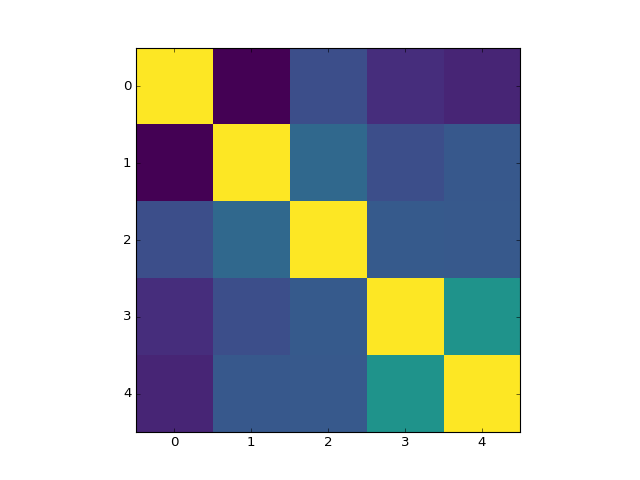

In [414]:
j = 4
k = 6
plt.imshow(np.dot(popvec[:,j,k,:].T,popvec[:,j,k,:]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)

<IPython.core.display.Javascript object>


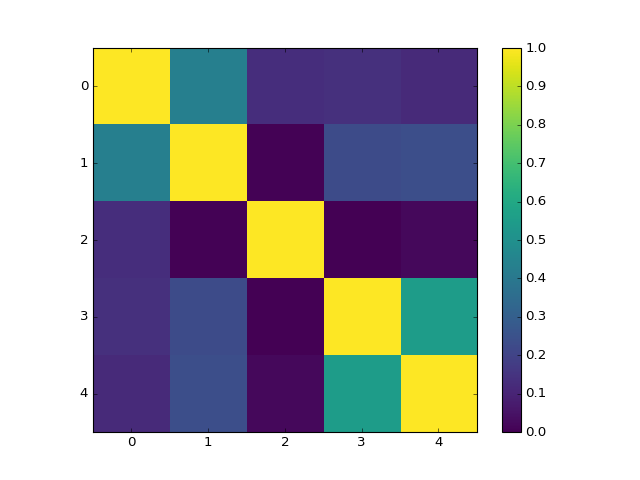

In [389]:
plt.imshow(np.abs(D[:20,:20]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


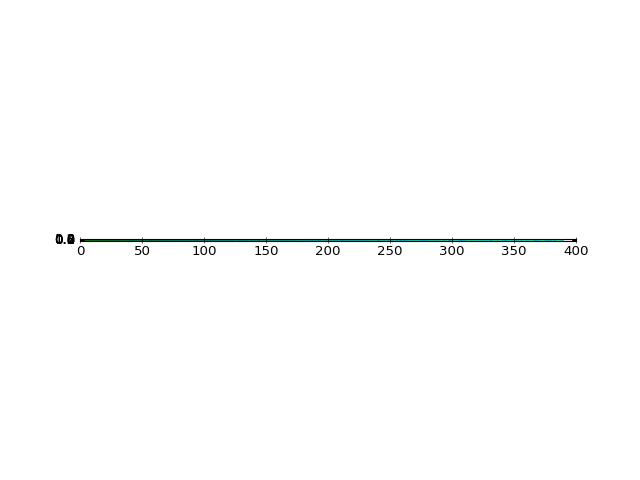

In [332]:
plt.plot(np.cumsum(scross/scross.sum()))
plt.plot(np.cumsum(sfig/sfig.sum()))

<IPython.core.display.Javascript object>


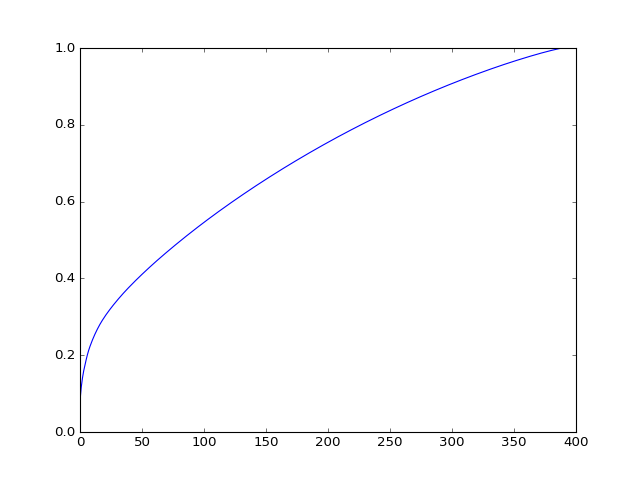

In [313]:
plt.plot(np.cumsum(s/s.sum()))

In [245]:
lincross = ontarget[:,0]+ontarget[:,1]
cross = ontarget[:,3]
liniso = ontarget[:,0]+ontarget[:,1,np.append(np.arange(6,8),np.arange(0,6))]
iso = ontarget[:,2]

<IPython.core.display.Javascript object>


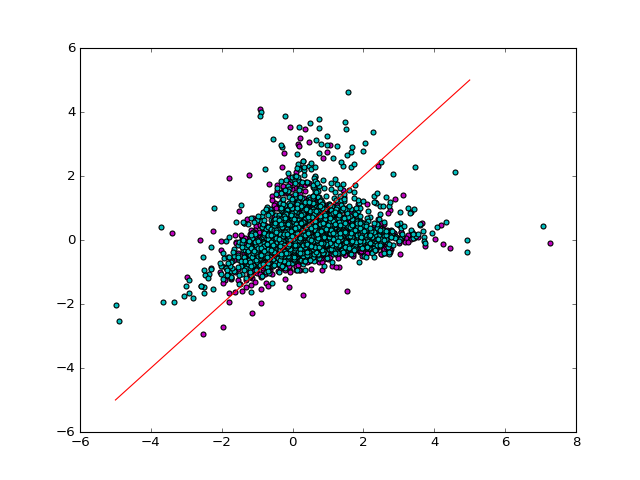

In [252]:
plt.scatter(liniso.flatten(),iso.flatten(),c='m')
plt.scatter(lincross.flatten(),cross.flatten(),c='c')
plt.plot((-5,5),(-5,5),c='r')

<IPython.core.display.Javascript object>


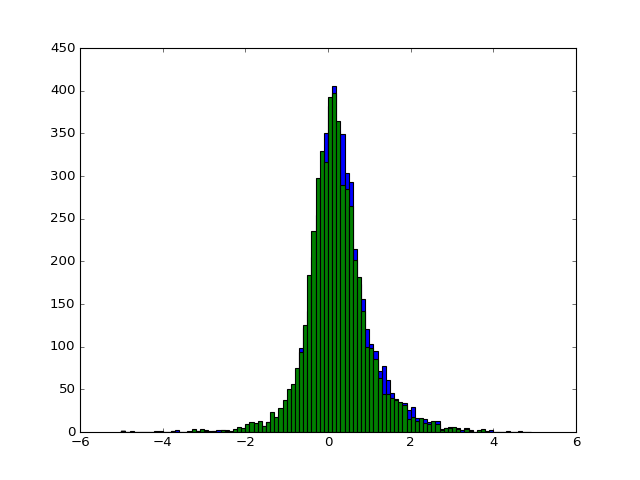

In [284]:
hiso = plt.hist(liniso.flatten()-iso.flatten(),bins=np.arange(-5,5,0.1))
hcross = plt.hist(lincross.flatten()-cross.flatten(),bins=np.arange(-5,5,0.1))

<IPython.core.display.Javascript object>


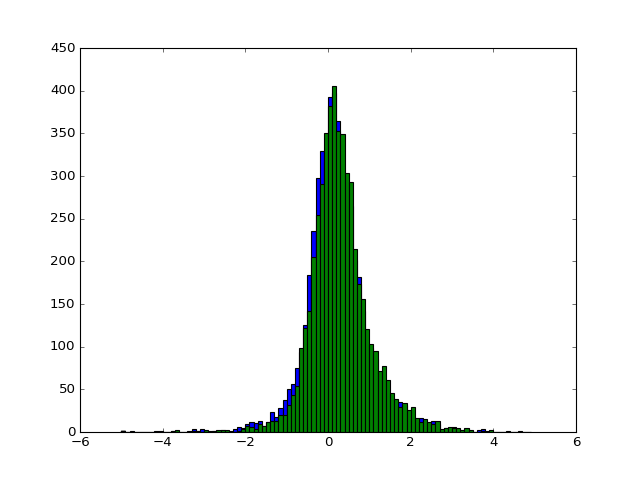

In [278]:
hiso[0].shape

(99,)

In [279]:
np.arange(-5,5,0.1).shape

(100,)